<a href="https://colab.research.google.com/github/shambakey1/water_pollution/blob/main/hybrid_model_and_others.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
# ===========================================
# كود سمر عنتر  مقارنة شاملة لخوارزميات التنبؤ متعدد الإخراج
# مع معالجة القيم المفقودة والبيانات
# ===========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer

# traditional ML models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neural_network import MLPRegressor

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping

print(" المكتبات تم تحميلها بنجاح!")

 المكتبات تم تحميلها بنجاح!



 التحقق من جودة البيانات:
 شكل البيانات: (8589, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8589 entries, 0 to 8588
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   t         8589 non-null   float64
 1   C(x=0.5)  8589 non-null   float64
 2   C(x=1)    8589 non-null   float64
 3   C(x=2)    8589 non-null   float64
 4   C(x=2.5)  8589 non-null   float64
 5   C(x=3)    8589 non-null   float64
 6   C(x=3.5)  8589 non-null   float64
 7   C(x=4)    8589 non-null   float64
 8   C(x=4.5)  8589 non-null   float64
 9   C(x=5)    8589 non-null   float64
 10  C(x=5.5)  8589 non-null   float64
 11  C(x=6)    8589 non-null   float64
dtypes: float64(12)
memory usage: 805.3 KB
None

 القيم المفقودة:
t           0
C(x=0.5)    0
C(x=1)      0
C(x=2)      0
C(x=2.5)    0
C(x=3)      0
C(x=3.5)    0
C(x=4)      0
C(x=4.5)    0
C(x=5)      0
C(x=5.5)    0
C(x=6)      0
dtype: int64

 الإحصائيات الوصفية:
                  t     C

/tmp/ipython-input-1988334134.py:65: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_clean[target_cols].hist(ax=axes[1,0], bins=30, alpha=0.7)
/tmp/ipython-input-1988334134.py:84: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


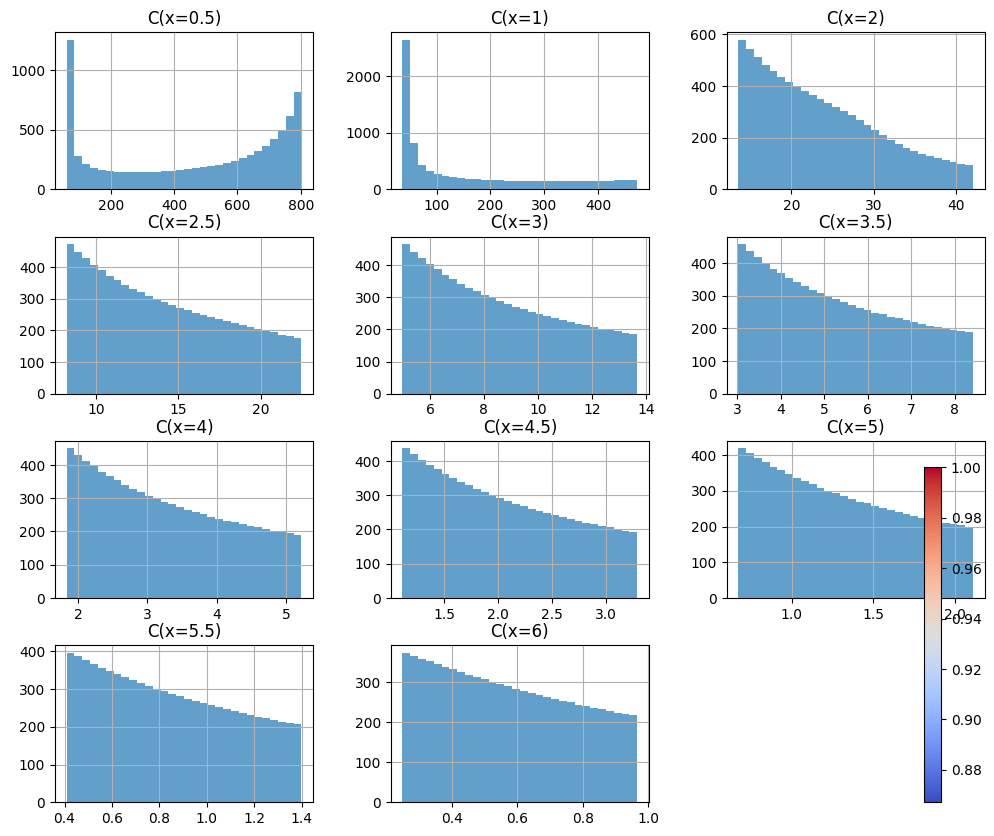

In [33]:
# =========================
# قراءة الداتا بالكامل
# =========================
df = pd.read_csv("C_vs_t_multi_x_50000.csv")

# كل الأعمدة بعد الت هي الهدف — تلقائيًا
target_cols = df.columns[1:]

# =========================
#  التحقق من جودة البيانات
# =========================
print("\n التحقق من جودة البيانات:")
print(f" شكل البيانات: {df.shape}")
print(df.info())
print("\n القيم المفقودة:")
print(df.isnull().sum())
print("\n الإحصائيات الوصفية:")
print(df.describe())


# =========================
# تنظيف البيانات (نسخة جديدة متوافقة مع target_cols)
# =========================
def clean_data(df, target_cols):
    df_clean = df.copy()

    print(f"\n عدد القيم المفقودة قبل التنظيف: {df_clean.isnull().sum().sum()}")

    # إزالة الصفوف التي تحتوي على قيم مفقودة في الأعمدة المستهدفة
    df_clean = df_clean.dropna(subset=target_cols)

    # إزالة القيم السالبة لو غير منطقية
    for col in target_cols:
        df_clean = df_clean[df_clean[col] >= 0]

    print(f" عدد القيم المفقودة بعد التنظيف: {df_clean.isnull().sum().sum()}")
    print(f" شكل البيانات بعد التنظيف: {df_clean.shape}")

    return df_clean

df_clean = clean_data(df, target_cols)


# =========================
# التحليل الاستكشافي (يتعامل تلقائيًا مع أي عدد أعمدة)
# =========================
def exploratory_analysis(df_clean, target_cols):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Scatter لكل عمود مستهدف
    for col in target_cols:
        axes[0,0].scatter(df_clean['t'], df_clean[col], alpha=0.5, s=10, label=col)

    axes[0,0].set_title("توزيع البيانات بعد التنظيف")
    axes[0,0].set_xlabel("t")
    axes[0,0].set_ylabel("C values")
    axes[0,0].legend()
    axes[0,0].grid(True)

    # Boxplot
    df_clean[target_cols].boxplot(ax=axes[0,1])
    axes[0,1].set_title("المخططات الصندوقية")

    # Histogram
    df_clean[target_cols].hist(ax=axes[1,0], bins=30, alpha=0.7)
    axes[1,0].set_title("التوزيع")

    # Correlation matrix
    corr_matrix = df_clean.corr()
    im = axes[1,1].imshow(corr_matrix.values, cmap='coolwarm', aspect='auto')
    axes[1,1].set_xticks(range(len(corr_matrix.columns)))
    axes[1,1].set_yticks(range(len(corr_matrix.columns)))
    axes[1,1].set_xticklabels(corr_matrix.columns, rotation=45)
    axes[1,1].set_yticklabels(corr_matrix.columns)
    plt.colorbar(im, ax=axes[1,1])
    axes[1,1].set_title("مصفوفة الارتباط")

    # أرقام الارتباط داخل المصفوفة
    for i in range(len(corr_matrix.columns)):
        for j in range(len(corr_matrix.columns)):
            axes[1,1].text(j, i, f"{corr_matrix.iloc[i, j]:.2f}",
                           ha="center", va="center", fontsize=8)

    plt.tight_layout()
    plt.show()

exploratory_analysis(df_clean, target_cols)


# =========================
# تجهيز X و y لباقي الخوارزميات
# =========================
X = df_clean[['t']].values
y = df_clean[target_cols].values

# قيم مفقودة بعد التنظيف؟
if np.isnan(y).sum() > 0:
    imputer = SimpleImputer(strategy='mean')
    y = imputer.fit_transform(y)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Scaling
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [34]:
# =========================
# تقسيم Train إلى Train + Validation
# =========================

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_scaled, y_train_scaled,
    test_size=0.2,   # نسبة الفاليديشن من الداتا التدريبية
    random_state=42,
    shuffle=True
)

print("\n أحجام البيانات بعد التقسيم:")
print("X_train_final:", X_train_final.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test_scaled.shape)



 أحجام البيانات بعد التقسيم:
X_train_final: (5496, 1)
X_val: (1375, 1)
X_test: (1718, 1)


In [35]:
# THIS CELL IS NOT IMPORTANT. IT WAS JUST DONE TO CALCULATE THE CORRECT MEAN OF
# Assuming your dataframe is named df_clean as per the notebook

correct_mean = y_test.mean()
print(f"The correct mean for SI calculation is: {correct_mean}")

# Then use your known RMSE
manual_si = 0.000102 / correct_mean
print(f"Corrected Scatter Index: {manual_si}")

The correct mean for SI calculation is: 61.87846200153208
Corrected Scatter Index: 1.64839261837947e-06


In [36]:
# =========================
# تعريف المقاييس (Metrics)
# =========================

def correlation_coefficient(y_true, y_pred):
    """معامل الارتباط"""
    return np.corrcoef(y_true.flatten(), y_pred.flatten())[0, 1]

def scatter_index(y_true, y_pred):
    """Scatter Index"""
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mean_true = np.mean(y_true)
    return rmse / mean_true

def willmott_index(y_true, y_pred):
    """Willmott Index"""
    mean_true = np.mean(y_true)
    numerator = np.sum((y_true - y_pred)**2)
    denominator = np.sum((np.abs(y_pred - mean_true) + np.abs(y_true - mean_true))**2)
    return 1 - numerator / denominator

def evaluate_model(y_true, y_pred):
    """إرجاع كل المقاييس دفعة واحدة"""
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    cc = correlation_coefficient(y_true, y_pred)
    si = scatter_index(y_true, y_pred)
    wi = willmott_index(y_true, y_pred)

    return {
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2,
        "CC": cc,
        "SI": si,
        "WI": wi
    }


In [37]:

# =========================
# تعريف النماذج التقليدية
# ========================ماذج
from sklearn.linear_model import LinearRegression
models = {
    "Linear Regression": LinearRegression(),
    #"KNN": KNeighborsRegressor(n_neighbors=1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
   # "Bagged Model": BaggingRegressor(RandomForestRegressor(), n_estimators=6, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "SVM (RBF Kernel)": SVR(kernel='rbf', C=10),
    "Linear SVM": LinearSVR(random_state=42, max_iter=5000),
   # "Ridge Regression": Ridge(alpha=1.0),
    #"MLP (Shallow)": MLPRegressor(hidden_layer_sizes=(50,50), max_iter=1000, random_state=42),
    "MLP ": MLPRegressor(hidden_layer_sizes=(100,100,50), max_iter=2000, random_state=42),
  #  "Deep MLP Extra": MLPRegressor(hidden_layer_sizes=(200,150,100,50), max_iter=3000, random_state=42)
}


In [38]:

results = []

# النماذج التي تحتاج MultiOutputRegressor
single_output_models_names = ["Gradient Boosting", "SVM (RBF Kernel)", "Linear SVM"]

for name, model in models.items():
    print(f"Training {name}...")
    start_train = time.time()

    current_model = model
    # تغليف النماذج أحادية المخرجات
    if name in single_output_models_names:
        current_model = MultiOutputRegressor(model)

    current_model.fit(X_train_final, y_train_final)
    train_time = time.time() - start_train

    start_pred = time.time()
    # التنبؤ على validation
    y_val_pred = current_model.predict(X_val)
    # التنبؤ على test
    y_test_pred = current_model.predict(X_test_scaled)
    pred_time = time.time() - start_pred

    # تحويل القيم للعادية
    y_val_true = scaler_y.inverse_transform(y_val)
    y_val_pred = scaler_y.inverse_transform(y_val_pred)
    y_test_true = scaler_y.inverse_transform(y_test_scaled)
    y_test_pred = scaler_y.inverse_transform(y_test_pred)

    val_metrics = evaluate_model(y_val_true, y_val_pred)
    test_metrics = evaluate_model(y_test_true, y_test_pred)

    results.append({
        "Model": name,
        "Validation MSE": val_metrics["MSE"],
        "Validation MAE": val_metrics["MAE"],
        "Validation RMSE": val_metrics["RMSE"],
        "Validation R²": val_metrics["R²"],
        "Validation CC": val_metrics["CC"],
        "Validation SI": val_metrics["SI"],
        "Validation WI": val_metrics["WI"],
        "Test MSE": test_metrics["MSE"],
        "Test MAE": test_metrics["MAE"],
        "Test RMSE": test_metrics["RMSE"],
        "Test R²": test_metrics["R²"],
        "Test CC": test_metrics["CC"],
        "Test SI": test_metrics["SI"],
        "Test WI": test_metrics["WI"],
        "Train Time": train_time,
        "Pred Time": pred_time
    })

# =========================
# تحويل النتائج ل DataFrame وعرضها
# =========================
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Test R²", ascending=False)
print("\n===================جدول مقارنة النماذج ===================")
print(results_df.to_string(index=False))

Training Linear Regression...
Training Random Forest...
Training Gradient Boosting...
Training SVM (RBF Kernel)...
Training Linear SVM...
Training MLP ...

===================جدول مقارنة النماذج ===================
            Model  Validation MSE  Validation MAE  Validation RMSE  Validation R²  Validation CC  Validation SI  Validation WI   Test MSE  Test MAE  Test RMSE  Test R²  Test CC  Test SI  Test WI  Train Time  Pred Time
    Random Forest        0.000884        0.008798         0.029737       1.000000       1.000000       0.000471       1.000000   0.000804  0.008421   0.028355 1.000000 1.000000 0.000458 1.000000    1.597027   0.113921
             MLP         0.379911        0.192731         0.616369       0.999961       0.999993       0.009752       0.999996   0.406166  0.195189   0.637312 0.999961 0.999992 0.010299 0.999996    1.438346   0.034731
Gradient Boosting        0.237626        0.146337         0.487469       0.999954       0.999996       0.007713       0.999998   0.

In [39]:
# =========================================
# إعداد بيانات النماذج العميقة (Multi-Output)
# =========================================

# استخدام نفس بيانات التدريب بعد التقسيم النهائي
X_train_dl = X_train_final.reshape((X_train_final.shape[0], 1, X_train_final.shape[1]))
X_val_dl   = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_dl  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

n_outputs = y_train_final.shape[1]  # عدد الـ targets

# Early stopping
es = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

results_dl = []

# =========================================
# دالة التقييم الموحدة للنماذج العميقة
# =========================================
def evaluate_dl(model, X_train_dl, y_train_s,
                X_val_dl, y_val_s,
                X_test_dl, y_test_s,
                name):

    start_train = time.time()
    history = model.fit(
        X_train_dl,
        y_train_s,
        validation_data=(X_val_dl, y_val_s),
        epochs=200,
        callbacks=[es],
        verbose=0
    )
    train_time = time.time() - start_train

    start_pred = time.time()
    y_val_pred_s  = model.predict(X_val_dl)
    y_test_pred_s = model.predict(X_test_dl)
    pred_time = time.time() - start_pred

    # =====================
    # Inverse scaling
    # =====================
    y_val_true  = scaler_y.inverse_transform(y_val_s)
    y_val_pred  = scaler_y.inverse_transform(y_val_pred_s)

    y_test_true = scaler_y.inverse_transform(y_test_s)
    y_test_pred = scaler_y.inverse_transform(y_test_pred_s)

    val_metrics  = evaluate_model(y_val_true, y_val_pred)
    test_metrics = evaluate_model(y_test_true, y_test_pred)

    results_dl.append({
        "Model": name,
        "Validation MSE": val_metrics["MSE"],
        "Validation MAE": val_metrics["MAE"],
        "Validation RMSE": val_metrics["RMSE"],
        "Validation R²": val_metrics["R²"],
        "Validation CC": val_metrics["CC"],
        "Validation SI": val_metrics["SI"],
        "Validation WI": val_metrics["WI"],
        "Test MSE": test_metrics["MSE"],
        "Test MAE": test_metrics["MAE"],
        "Test RMSE": test_metrics["RMSE"],
        "Test R²": test_metrics["R²"],
        "Test CC": test_metrics["CC"],
        "Test SI": test_metrics["SI"],
        "Test WI": test_metrics["WI"],
        "Train Time": train_time,
        "Pred Time": pred_time
    })

    print(f" {name} finished | Val RMSE = {val_metrics['RMSE']:.4f}")
    return history


# =========================================
# LSTM
# =========================================
lstm = Sequential([
    Input(shape=(1, X_train_final.shape[1])),
    LSTM(50),
    Dense(n_outputs)
])
lstm.compile(optimizer='adam', loss='mse')

hist_lstm = evaluate_dl(
    lstm,
    X_train_dl, y_train_final,
    X_val_dl,   y_val,
    X_test_dl,  y_test_scaled,
    "LSTM"
)

# =========================================
# GRU
# =========================================
gru = Sequential([
    Input(shape=(1, X_train_final.shape[1])),
    GRU(50),
    Dense(n_outputs)
])
gru.compile(optimizer='adam', loss='mse')

hist_gru = evaluate_dl(
    gru,
    X_train_dl, y_train_final,
    X_val_dl,   y_val,
    X_test_dl,  y_test_scaled,
    "GRU"
)

# =========================================
# BiLSTM
# =========================================
bilstm = Sequential([
    Input(shape=(1, X_train_final.shape[1])),
    Bidirectional(LSTM(50)),
    Dense(n_outputs)
])
bilstm.compile(optimizer='adam', loss='mse')

hist_bilstm = evaluate_dl(
    bilstm,
    X_train_dl, y_train_final,
    X_val_dl,   y_val,
    X_test_dl,  y_test_scaled,
    "BiLSTM"
)

# =========================================
# Hybrid Model (Random Forest + MLP Residual)
# =========================================


# =========================
# تدريب Random Forest على كل الأعمدة
# =========================
start_train_rf = time.time()
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_final, y_train_final)  # multi-output
rf_train_time = time.time() - start_train_rf

# =========================
# حساب residuals لكل عمود هدف
# =========================
rf_pred_train = rf.predict(X_train_final)
residuals_train = y_train_final - rf_pred_train

# =========================
# Scale residuals
# =========================
scaler_res = StandardScaler()
residuals_train_scaled = scaler_res.fit_transform(residuals_train)

# =========================
# تدريب MLP على residuals (multi-output)
# =========================
mlp = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=1000, random_state=42)
mlp_multi = MultiOutputRegressor(mlp)

start_train_mlp = time.time()
mlp_multi.fit(X_train_final, residuals_train_scaled)
mlp_train_time = time.time() - start_train_mlp

# =========================
# توقع على Validation و Test مع الوقت الفعلي
# =========================
start_pred = time.time()
rf_pred_val  = rf.predict(X_val)
rf_pred_test = rf.predict(X_test_scaled)

residual_val_scaled  = mlp_multi.predict(X_val)
residual_test_scaled = mlp_multi.predict(X_test_scaled)
pred_time = time.time() - start_pred

# Inverse scale residuals
residual_val  = scaler_res.inverse_transform(residual_val_scaled)
residual_test = scaler_res.inverse_transform(residual_test_scaled)

# Hybrid prediction النهائي
hybrid_val_pred  = scaler_y.inverse_transform(rf_pred_val  + residual_val)
hybrid_test_pred = scaler_y.inverse_transform(rf_pred_test + residual_test)

# =========================
# تقييم Hybrid
# =========================
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    cc = np.corrcoef(y_true.flatten(), y_pred.flatten())[0, 1]
    si = rmse / np.mean(y_true)
    mean_true = np.mean(y_true)
    wi = 1 - np.sum((y_true - y_pred)**2) / np.sum((np.abs(y_pred - mean_true) + np.abs(y_true - mean_true))**2)

    return {
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2,
        "CC": cc,
        "SI": si,
        "WI": wi
    }

val_metrics  = evaluate_model(scaler_y.inverse_transform(y_val), hybrid_val_pred)
test_metrics = evaluate_model(scaler_y.inverse_transform(y_test_scaled), hybrid_test_pred)

# =========================
# حفظ النتائج مع الوقت الفعلي
# =========================
results_dl.append({
    "Model": "Hybrid RF + MLP (Residual) Corrected",
    "Validation MSE": val_metrics["MSE"],
    "Validation MAE": val_metrics["MAE"],
    "Validation RMSE": val_metrics["RMSE"],
    "Validation R²": val_metrics["R²"],
    "Validation CC": val_metrics["CC"],
    "Validation SI": val_metrics["SI"],
    "Validation WI": val_metrics["WI"],
    "Test MSE": test_metrics["MSE"],
    "Test MAE": test_metrics["MAE"],
    "Test RMSE": test_metrics["RMSE"],
    "Test R²": test_metrics["R²"],
    "Test CC": test_metrics["CC"],
    "Test SI": test_metrics["SI"],
    "Test WI": test_metrics["WI"],
    "Train Time": rf_train_time + mlp_train_time,
    "Pred Time": pred_time
})


print(" Hybrid RF + MLP (Residual) Corrected finished")


# =========================================
# جدول النتائج النهائي
# =========================================
results_dl_df = pd.DataFrame(results_dl)
results_dl_df = results_dl_df.sort_values("Test R²", ascending=False)

print("\n Deep Learning & Hybrid Results:")
print(results_dl_df.to_string(index=False))


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 LSTM finished | Val RMSE = 0.3909
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
 GRU finished | Val RMSE = 0.3397
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 BiLSTM finished | Val RMSE = 0.3478
 Hybrid RF + MLP (Residual) Corrected finished

 Deep Learning & Hybrid Results:
                               Model  Validation MSE  Validation MAE  Validation RMSE  Validation R²  Validation CC  Validation SI  Validation WI  Test MSE  Test MAE  Test RMSE  Test R²  Test CC  Test SI  Test WI  Train Time  Pred Time
Hybrid RF + MLP (Residual) Corrected        0.000848        0.008455         0.029117       1.000000       1.000000       0.000461       1.000000  0.000771  0.008122   0.027768 1.000000 1.000000 0.000449 1.000000    5.854161   0.149586
                              BiLSTM        0.120941        0.083583         0.347765       0.999998      

In [40]:
# إضافة النموذج الهجين لقاموس models
models["Hybrid RF + MLP (Residual) Corrected"] = {
    "rf": rf,
    "mlp": mlp,
    "scaler_res": scaler_res
}

print(" تم إضافة Hybrid RF + MLP (Residual) Corrected إلى قاموس models")


 تم إضافة Hybrid RF + MLP (Residual) Corrected إلى قاموس models


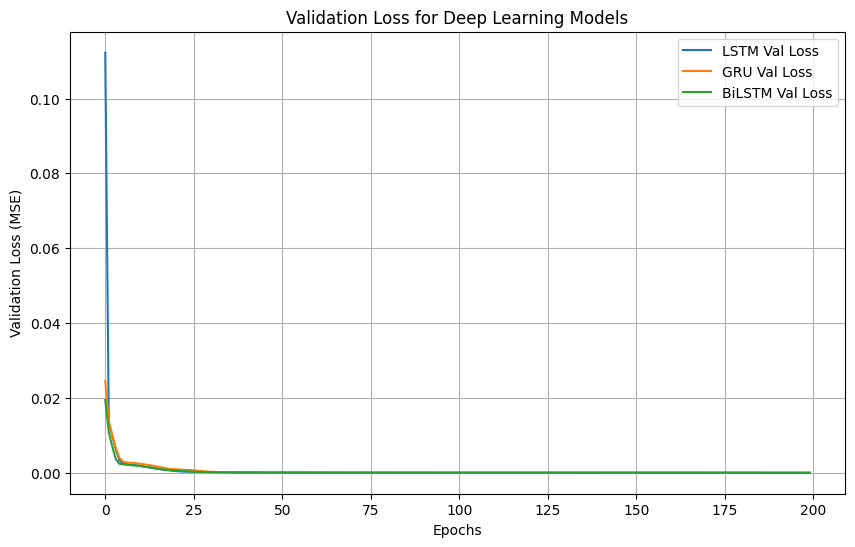

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


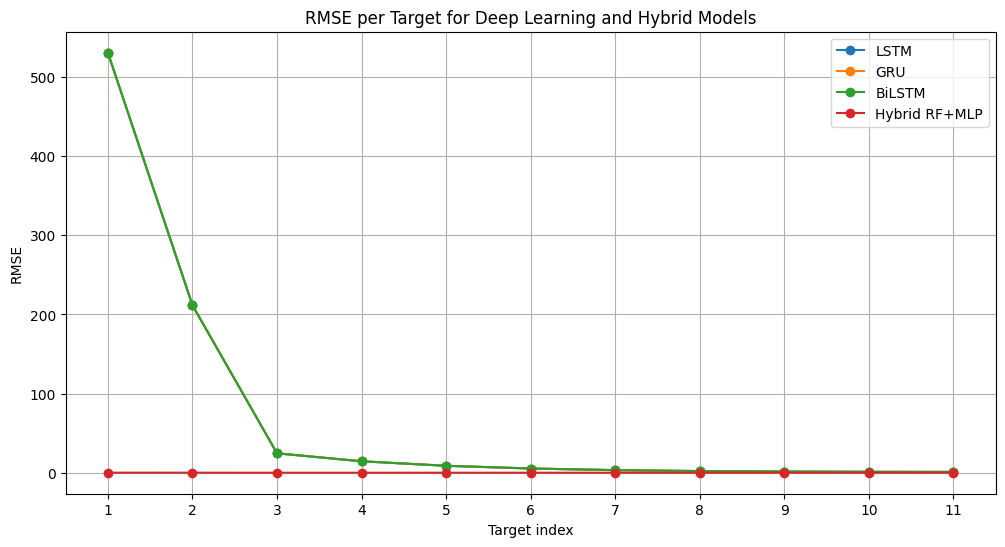

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# =========================
# رسم Validation Loss لكل الموديلات العميقة
# =========================
def plot_val_loss(histories, model_names):
    plt.figure(figsize=(10,6))
    for hist, name in zip(histories, model_names):
        plt.plot(hist.history['val_loss'], label=f'{name} Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss (MSE)')
    plt.title('Validation Loss for Deep Learning Models')
    plt.legend()
    plt.grid(True)
    plt.show()

# استخدمنا القيم اللي خزنتها من hist_lstm, hist_gru, hist_bilstm
plot_val_loss([hist_lstm, hist_gru, hist_bilstm], ['LSTM', 'GRU', 'BiLSTM'])

# =========================
#  رسم RMSE لكل Target لكل موديل (Deep + Hybrid)
# =========================
def plot_rmse_per_target(y_true_dict, y_pred_dict, model_names):
    n_targets = y_true_dict[model_names[0]].shape[1]
    x = np.arange(1, n_targets+1)

    plt.figure(figsize=(12,6))
    for name in model_names:
        rmse_values = [np.sqrt(mean_squared_error(y_true_dict[name][:,i], y_pred_dict[name][:,i]))
                       for i in range(n_targets)]
        plt.plot(x, rmse_values, marker='o', label=name)

    plt.xlabel('Target index')
    plt.ylabel('RMSE')
    plt.title('RMSE per Target for Deep Learning and Hybrid Models')
    plt.xticks(x)
    plt.legend()
    plt.grid(True)
    plt.show()

# =========================
# تحضير البيانات
# =========================
hybrid_pred = hybrid_test_pred
y_true_dict = {
    'LSTM': y_test,
    'GRU': y_test,
    'BiLSTM': y_test,
    'Hybrid RF+MLP': y_test
}

y_pred_dict = {
    'LSTM': lstm.predict(X_test_dl),
    'GRU': gru.predict(X_test_dl),
    'BiLSTM': bilstm.predict(X_test_dl),
    'Hybrid RF+MLP': hybrid_pred
}

plot_rmse_per_target(y_true_dict, y_pred_dict, ['LSTM','GRU','BiLSTM','Hybrid RF+MLP'])


In [42]:
print("Columns in results_df:", results_df.columns.tolist())
print("Columns in results_dl_df:", results_dl_df.columns.tolist())


Columns in results_df: ['Model', 'Validation MSE', 'Validation MAE', 'Validation RMSE', 'Validation R²', 'Validation CC', 'Validation SI', 'Validation WI', 'Test MSE', 'Test MAE', 'Test RMSE', 'Test R²', 'Test CC', 'Test SI', 'Test WI', 'Train Time', 'Pred Time']
Columns in results_dl_df: ['Model', 'Validation MSE', 'Validation MAE', 'Validation RMSE', 'Validation R²', 'Validation CC', 'Validation SI', 'Validation WI', 'Test MSE', 'Test MAE', 'Test RMSE', 'Test R²', 'Test CC', 'Test SI', 'Test WI', 'Train Time', 'Pred Time']


In [43]:
# =========================
# دمج جداول التقليدية والعميقة/Hybrid مع جميع الأعمدة
# =========================

# نسخ الجداول
df_trad_full = results_df.copy()
df_deep_full = results_dl_df.drop(columns=['History'], errors='ignore').copy()  # نحذف عمود History لو موجود

# دمج الجداول
comparison_full_df = pd.concat([df_trad_full, df_deep_full], ignore_index=True)

# ترتيب حسب Test RMSE تصاعديًا (الأفضل أولًا)
comparison_full_df = comparison_full_df.sort_values(by='Test RMSE', ascending=True).reset_index(drop=True)

print("\nجدول مقارنة شامل بكل الأعمدة بين التقليدية والعميقة/Hybrid:")
print(comparison_full_df)

# =========================
# اختيار أفضل موديل
# =========================
best_model_row = comparison_full_df.iloc[0]
print(f"\n أفضل موديل حسب RMSE: {best_model_row['Model']} | RMSE = {best_model_row['Test RMSE']:.4f}, R² = {best_model_row['Test R²']:.4f}")



جدول مقارنة شامل بكل الأعمدة بين التقليدية والعميقة/Hybrid:
                                  Model  Validation MSE  Validation MAE  \
0  Hybrid RF + MLP (Residual) Corrected        0.000848        0.008455   
1                         Random Forest        0.000884        0.008798   
2                                   GRU        0.115396        0.090029   
3                                BiLSTM        0.120941        0.083583   
4                                  LSTM        0.152788        0.104729   
5                     Gradient Boosting        0.237626        0.146337   
6                                  MLP         0.379911        0.192731   
7                      SVM (RBF Kernel)       36.234105        2.264997   
8                     Linear Regression      440.887446        8.051836   
9                            Linear SVM      459.853331        8.069510   

   Validation RMSE  Validation R²  Validation CC  Validation SI  \
0         0.029117       1.000000       1.0000

/tmp/ipython-input-904752866.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_targets)


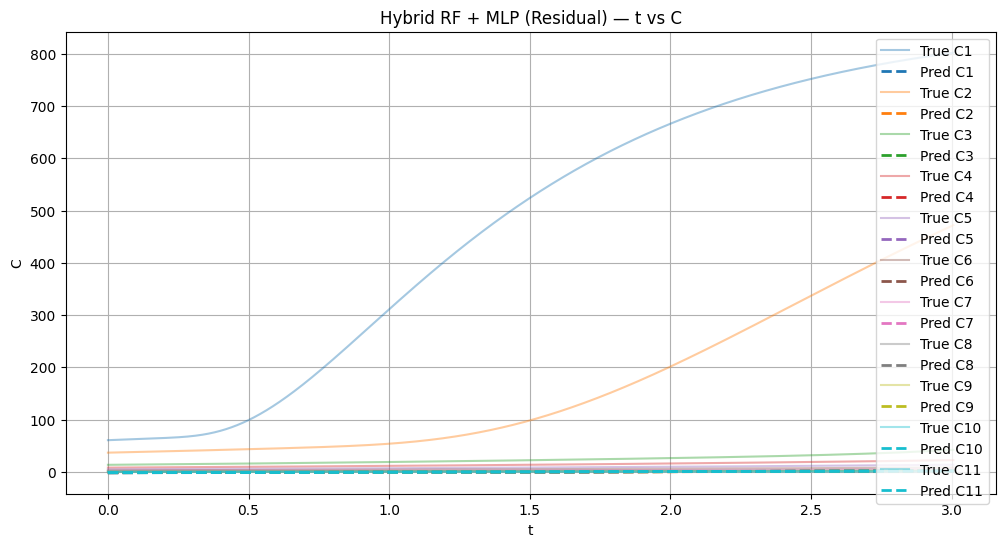

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# =========================
# X كامل (Train + Test)
# =========================
X_full = np.vstack([X_train_final, X_test_scaled])

# t الحقيقي
t_full = scaler_X.inverse_transform(X_full)[:, 0]

# y الحقيقي
y_true_full = np.vstack([y_train_final, y_test_scaled])
y_true_full = scaler_y.inverse_transform(y_true_full)

# =========================
# Hybrid Prediction (الصحيح)
# =========================
rf_pred_full = rf.predict(X_full)

# ✅ MLP يأخذ X_full (مش rf_pred)
residual_full_scaled = mlp_multi.predict(X_full)
residual_full = scaler_res.inverse_transform(residual_full_scaled)

y_pred_full = rf_pred_full + residual_full

# =========================
# ترتيب حسب t
# =========================
idx = np.argsort(t_full)
t_sorted = t_full[idx]

# =========================
# رسم المنحنيات
# =========================
n_targets = y_true_full.shape[1]
plt.figure(figsize=(12,6))
colors = plt.cm.get_cmap('tab10', n_targets)

t_smooth = np.linspace(t_sorted.min(), t_sorted.max(), 2000)

for i in range(n_targets):

    # True
    y_true_sorted = y_true_full[idx, i]
    spline_true = make_interp_spline(t_sorted, y_true_sorted)
    y_true_smooth = spline_true(t_smooth)

    plt.plot(
        t_smooth, y_true_smooth,
        color=colors(i), alpha=0.4,
        label=f'True C{i+1}'
    )

    # Predicted
    y_pred_sorted = y_pred_full[idx, i]
    spline_pred = make_interp_spline(t_sorted, y_pred_sorted)
    y_pred_smooth = spline_pred(t_smooth)

    plt.plot(
        t_smooth, y_pred_smooth,
        linestyle='--', linewidth=2,
        color=colors(i),
        label=f'Pred C{i+1}'
    )

plt.xlabel('t')
plt.ylabel('C')
plt.title('Hybrid RF + MLP (Residual) — t vs C')
plt.legend()
plt.grid(True)
plt.show()

 Using best model: Hybrid RF + MLP (Residual) Corrected


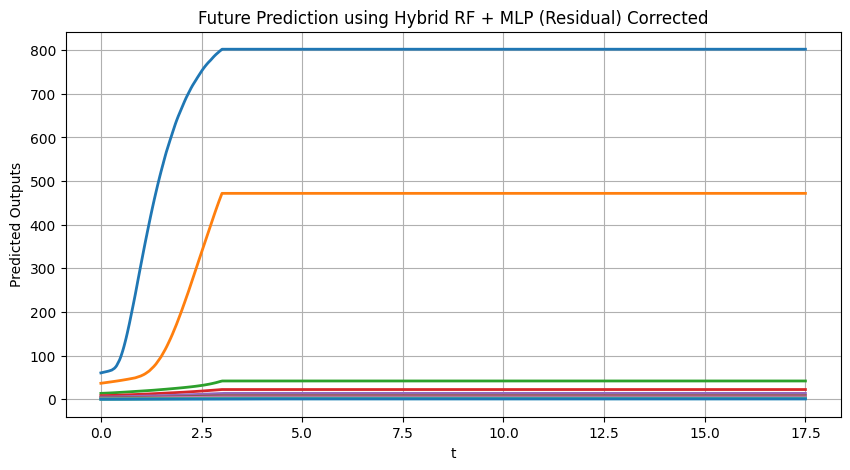

In [45]:
 # ======================
# التنبؤ عند قيم جديدة من t (FINAL VERSION)
# ======================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor

# ======================
# تجهيز بيانات جديدة بنفس شكل X_train
# ======================
t_new = np.zeros((50000, X_train.shape[1]))   # نفس عدد الـ features
t_new[:, 0] = np.linspace(0, 17.5, 50000)      # t هو العمود الأول

# استخدام نفس scaler الخاص بـ X
t_new_scaled = scaler_X.transform(t_new)

# ======================
# اختيار أفضل موديل
# ======================
best_model_name = best_model_row['Model']
print(f" Using best model: {best_model_name}")

# ======================
# التنبؤ حسب نوع النموذج
# ======================

# -------- Hybrid RF + MLP --------
if best_model_name == "Hybrid RF + MLP (Residual) Corrected":

    #  توقعات RF على t_new_scaled
    rf_pred = rf.predict(t_new_scaled)

   # إذا كانت المخرجات متعددة، نتأكد من استخدام MultiOutputRegressor للـ MLP
    if y_train.shape[1] > 1:
        mlp_multi = MultiOutputRegressor(mlp)
        mlp_multi.fit(rf.predict(X_train_scaled), y_train - rf.predict(X_train_scaled))
        residual = mlp_multi.predict(rf_pred)
    else:
        residual = mlp.predict(rf_pred.reshape(-1, 1))

    #  جمع RF + residual للحصول على التوقع النهائي
    y_new_pred = rf_pred + residual

# -------- Deep Learning Models --------
elif best_model_name in ["LSTM", "GRU", "BiLSTM"]:

    t_new_dl = t_new_scaled.reshape(
        (t_new_scaled.shape[0], t_new_scaled.shape[1], 1)
    )

    if best_model_name == "LSTM":
        y_new_pred = lstm.predict(t_new_dl)
    elif best_model_name == "GRU":
        y_new_pred = gru.predict(t_new_dl)
    elif best_model_name == "BiLSTM":
        y_new_pred = bilstm.predict(t_new_dl)

# -------- Traditional ML Models --------
elif best_model_name in models:

    y_new_pred_scaled = models[best_model_name].predict(t_new_scaled)
    y_new_pred = scaler_y.inverse_transform(y_new_pred_scaled)

else:
    raise ValueError(f" Model {best_model_name} not supported")

# ======================
# الرسم
# ======================
plt.figure(figsize=(10,5))
plt.plot(t_new[:, 0], y_new_pred, linewidth=2)
plt.xlabel('t')
plt.ylabel('Predicted Outputs')
plt.title(f'Future Prediction using {best_model_name}')
plt.grid(True)
plt.show()


In [47]:
# =========================
# COMPLETE SOLUTION: Save Models, Data, and Predictions
# =========================

import pickle
import os
from datetime import datetime

# Create directories for saving
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f"model_results_{timestamp}"
os.makedirs(save_dir, exist_ok=True)

models_dir = os.path.join(save_dir, "models")
data_dir = os.path.join(save_dir, "data")
predictions_dir = os.path.join(save_dir, "predictions")

os.makedirs(models_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)
os.makedirs(predictions_dir, exist_ok=True)

print(f"\n✓ Created directory structure: {save_dir}")

# =========================
# 1. Save Train/Val/Test Data as CSV
# =========================

# Convert scaled data back to original scale
X_train_original = scaler_X.inverse_transform(X_train_final)
X_val_original = scaler_X.inverse_transform(X_val)
X_test_original = scaler_X.inverse_transform(X_test_scaled)

y_train_original = scaler_y.inverse_transform(y_train_final)
y_val_original = scaler_y.inverse_transform(y_val)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Create DataFrames with proper column names
train_df = pd.DataFrame(
    np.hstack([X_train_original, y_train_original]),
    columns=['t'] + list(target_cols)
)
val_df = pd.DataFrame(
    np.hstack([X_val_original, y_val_original]),
    columns=['t'] + list(target_cols)
)
test_df = pd.DataFrame(
    np.hstack([X_test_original, y_test_original]),
    columns=['t'] + list(target_cols)
)

# Save to CSV
train_df.to_csv(os.path.join(data_dir, "train_data.csv"), index=False)
val_df.to_csv(os.path.join(data_dir, "validation_data.csv"), index=False)
test_df.to_csv(os.path.join(data_dir, "test_data.csv"), index=False)

print(f"✓ Saved train/validation/test data to {data_dir}")

# =========================
# 2. Re-fit and Store ALL Models Properly
# =========================

fitted_models = {}

# List of models that need MultiOutputRegressor wrapper
single_output_models_names = ["Gradient Boosting", "SVM (RBF Kernel)", "Linear SVM"]

# Re-define the base models (fresh instances)
base_models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "SVM (RBF Kernel)": SVR(kernel='rbf', C=10),
    "Linear SVM": LinearSVR(random_state=42, max_iter=5000),
    "MLP": MLPRegressor(hidden_layer_sizes=(100,100,50), max_iter=2000, random_state=42)
}

# Train and store all traditional ML models
print("\nRe-fitting traditional ML models...")
for name, model in base_models.items():
    print(f"  Fitting {name}...")

    current_model = model

    # Wrap single-output models
    if name in single_output_models_names:
        current_model = MultiOutputRegressor(model)

    # Fit the model
    current_model.fit(X_train_final, y_train_final)

    # Store the FITTED model
    fitted_models[name] = current_model

# Store hybrid model (already fitted during training)
print("  Storing Hybrid RF + MLP...")
fitted_models["Hybrid RF + MLP (Residual) Corrected"] = {
    'rf': rf,
    'mlp': mlp_multi,
    'scaler_res': scaler_res
}

print("✓ All traditional ML models fitted and stored")

# =========================
# 3. Save All Models to Disk
# =========================

print("\nSaving models to disk...")

# Save traditional ML models
for name, model in fitted_models.items():
    safe_name = name.replace(' ', '_').replace('(', '').replace(')', '').replace('+', '')

    if name == "Hybrid RF + MLP (Residual) Corrected":
        # Save hybrid model components
        with open(os.path.join(models_dir, f"{safe_name}.pkl"), 'wb') as f:
            pickle.dump(model, f)
    else:
        # Save regular models
        with open(os.path.join(models_dir, f"{safe_name}.pkl"), 'wb') as f:
            pickle.dump(model, f)

# Save deep learning models
lstm.save(os.path.join(models_dir, "LSTM.h5"))
gru.save(os.path.join(models_dir, "GRU.h5"))
bilstm.save(os.path.join(models_dir, "BiLSTM.h5"))

# Save scalers (essential for loading models later)
with open(os.path.join(models_dir, "scaler_X.pkl"), 'wb') as f:
    pickle.dump(scaler_X, f)
with open(os.path.join(models_dir, "scaler_y.pkl"), 'wb') as f:
    pickle.dump(scaler_y, f)

print(f"✓ Saved all models to {models_dir}")

# =========================
# 4. Generate and Save Predictions for All Models
# =========================

def save_predictions(model, model_name, X_val_input, X_test_input, y_val_true, y_test_true, is_dl=False):
    """Generate and save predictions for validation and test sets"""

    try:
        # Get predictions
        if is_dl:
            # Reshape for deep learning models
            X_val_dl = X_val_input.reshape((X_val_input.shape[0], 1, X_val_input.shape[1]))
            X_test_dl = X_test_input.reshape((X_test_input.shape[0], 1, X_test_input.shape[1]))

            val_pred_scaled = model.predict(X_val_dl, verbose=0)
            test_pred_scaled = model.predict(X_test_dl, verbose=0)

            # Convert to original scale
            val_pred = scaler_y.inverse_transform(val_pred_scaled)
            test_pred = scaler_y.inverse_transform(test_pred_scaled)

        elif model_name == "Hybrid RF + MLP (Residual) Corrected":
            # Hybrid model prediction
            rf_pred_val = model['rf'].predict(X_val_input)
            rf_pred_test = model['rf'].predict(X_test_input)

            residual_val_scaled = model['mlp'].predict(X_val_input)
            residual_test_scaled = model['mlp'].predict(X_test_input)

            residual_val = model['scaler_res'].inverse_transform(residual_val_scaled)
            residual_test = model['scaler_res'].inverse_transform(residual_test_scaled)

            # Hybrid prediction (already in original scale)
            val_pred = scaler_y.inverse_transform(rf_pred_val + residual_val)
            test_pred = scaler_y.inverse_transform(rf_pred_test + residual_test)

        else:
            # Traditional ML models
            val_pred_scaled = model.predict(X_val_input)
            test_pred_scaled = model.predict(X_test_input)

            # Convert to original scale
            val_pred = scaler_y.inverse_transform(val_pred_scaled)
            test_pred = scaler_y.inverse_transform(test_pred_scaled)

        # Prepare validation predictions DataFrame
        val_predictions_df = pd.DataFrame({
            't': X_val_original[:, 0]
        })

        # Add actual and predicted values for each target
        for i, col in enumerate(target_cols):
            val_predictions_df[f'{col}_actual'] = y_val_true[:, i]
            val_predictions_df[f'{col}_predicted'] = val_pred[:, i]

        # Prepare test predictions DataFrame
        test_predictions_df = pd.DataFrame({
            't': X_test_original[:, 0]
        })

        # Add actual and predicted values for each target
        for i, col in enumerate(target_cols):
            test_predictions_df[f'{col}_actual'] = y_test_true[:, i]
            test_predictions_df[f'{col}_predicted'] = test_pred[:, i]

        # Save to CSV
        safe_name = model_name.replace(' ', '_').replace('(', '').replace(')', '').replace('+', '')
        val_predictions_df.to_csv(
            os.path.join(predictions_dir, f"{safe_name}_validation_predictions.csv"),
            index=False
        )
        test_predictions_df.to_csv(
            os.path.join(predictions_dir, f"{safe_name}_test_predictions.csv"),
            index=False
        )

        print(f"  ✓ Saved predictions for {model_name}")
        return val_pred, test_pred

    except Exception as e:
        print(f"  ✗ Error saving predictions for {model_name}: {str(e)}")
        return None, None

print("\nGenerating and saving predictions...")

# Save predictions for all traditional ML models
for name, model in fitted_models.items():
    save_predictions(model, name, X_val, X_test_scaled, y_val_original, y_test_original)

# Save predictions for deep learning models
save_predictions(lstm, "LSTM", X_val, X_test_scaled, y_val_original, y_test_original, is_dl=True)
save_predictions(gru, "GRU", X_val, X_test_scaled, y_val_original, y_test_original, is_dl=True)
save_predictions(bilstm, "BiLSTM", X_val, X_test_scaled, y_val_original, y_test_original, is_dl=True)

print(f"\n✓ Saved all predictions to {predictions_dir}")

# =========================
# 5. Save Comparison Results
# =========================

comparison_full_df.to_csv(
    os.path.join(save_dir, "model_comparison_results.csv"),
    index=False
)

print(f"✓ Saved comparison results to {save_dir}")

# =========================
# 6. Create Summary Report
# =========================

summary = f"""
Model Training and Evaluation Summary
{'='*80}

Date: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

Dataset Information:
- Total samples: {len(df_clean)}
- Training samples: {len(X_train_final)}
- Validation samples: {len(X_val)}
- Test samples: {len(X_test_scaled)}
- Number of targets: {n_outputs}
- Target columns: {', '.join(target_cols)}

Best Model: {best_model_name}
- Test RMSE: {best_model_row['Test RMSE']:.6f}
- Test R²: {best_model_row['Test R²']:.6f}
- Test MAE: {best_model_row['Test MAE']:.6f}
- Test CC: {best_model_row['Test CC']:.6f}
- Test SI: {best_model_row['Test SI']:.6f}
- Test WI: {best_model_row['Test WI']:.6f}

Top 5 Models by Test RMSE:
{'='*80}
"""

for idx, row in comparison_full_df.head(5).iterrows():
    summary += f"\n{idx+1}. {row['Model']}\n"
    summary += f"   - Test RMSE: {row['Test RMSE']:.6f}\n"
    summary += f"   - Test R²: {row['Test R²']:.6f}\n"
    summary += f"   - Train Time: {row['Train Time']:.2f}s\n"

summary += f"\n{'='*80}\n"
summary += f"\nSaved Files:\n"
summary += f"- Models: {models_dir}\n"
summary += f"- Data: {data_dir}\n"
summary += f"- Predictions: {predictions_dir}\n"
summary += f"- Comparison: model_comparison_results.csv\n"
summary += f"\n{'='*80}\n"

with open(os.path.join(save_dir, "summary_report.txt"), 'w', encoding='utf-8') as f:
    f.write(summary)

print(summary)

# =========================
# 7. Create Loading Instructions
# =========================

load_example = """
# ============================================================================
# HOW TO LOAD AND USE SAVED MODELS
# ============================================================================

import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# ----------------------------------------------------------------------------
# 1. Load Scalers (Required for all models)
# ----------------------------------------------------------------------------

with open('models/scaler_X.pkl', 'rb') as f:
    scaler_X = pickle.load(f)

with open('models/scaler_y.pkl', 'rb') as f:
    scaler_y = pickle.load(f)

# ----------------------------------------------------------------------------
# 2. Load Traditional ML Models
# ----------------------------------------------------------------------------

# Example: Load Random Forest
with open('models/Random_Forest.pkl', 'rb') as f:
    rf_model = pickle.load(f)

# Example: Load models wrapped in MultiOutputRegressor
with open('models/Gradient_Boosting.pkl', 'rb') as f:
    gb_model = pickle.load(f)

# ----------------------------------------------------------------------------
# 3. Load Deep Learning Models
# ----------------------------------------------------------------------------

lstm_model = tf.keras.models.load_model('models/LSTM.h5')
gru_model = tf.keras.models.load_model('models/GRU.h5')
bilstm_model = tf.keras.models.load_model('models/BiLSTM.h5')

# ----------------------------------------------------------------------------
# 4. Load Hybrid Model
# ----------------------------------------------------------------------------

with open('models/Hybrid_RF__MLP_Residual_Corrected.pkl', 'rb') as f:
    hybrid = pickle.load(f)
    rf = hybrid['rf']
    mlp = hybrid['mlp']
    scaler_res = hybrid['scaler_res']

# ----------------------------------------------------------------------------
# 5. Make Predictions with Traditional ML Model
# ----------------------------------------------------------------------------

# Prepare new data
new_t = np.array([[1.5], [2.0], [2.5]])  # Example time values
new_t_scaled = scaler_X.transform(new_t)

# Predict (scaled output)
prediction_scaled = rf_model.predict(new_t_scaled)

# Convert back to original scale
prediction = scaler_y.inverse_transform(prediction_scaled)

print("Predictions for t =", new_t.flatten())
print(prediction)

# ----------------------------------------------------------------------------
# 6. Make Predictions with Deep Learning Model
# ----------------------------------------------------------------------------

# Reshape for DL model (samples, timesteps, features)
new_t_dl = new_t_scaled.reshape((new_t_scaled.shape[0], 1, new_t_scaled.shape[1]))

# Predict
prediction_dl_scaled = lstm_model.predict(new_t_dl, verbose=0)

# Convert back to original scale
prediction_dl = scaler_y.inverse_transform(prediction_dl_scaled)

print("LSTM Predictions:", prediction_dl)

# ----------------------------------------------------------------------------
# 7. Make Predictions with Hybrid Model
# ----------------------------------------------------------------------------

# RF prediction
rf_pred = rf.predict(new_t_scaled)

# MLP residual prediction
residual_scaled = mlp.predict(new_t_scaled)
residual = scaler_res.inverse_transform(residual_scaled)

# Final hybrid prediction
hybrid_pred = scaler_y.inverse_transform(rf_pred + residual)

print("Hybrid Predictions:", hybrid_pred)

# ----------------------------------------------------------------------------
# 8. Load and Use Saved Data
# ----------------------------------------------------------------------------

# Load data
train_data = pd.read_csv('data/train_data.csv')
val_data = pd.read_csv('data/validation_data.csv')
test_data = pd.read_csv('data/test_data.csv')

# Load predictions
rf_val_predictions = pd.read_csv('predictions/Random_Forest_validation_predictions.csv')
rf_test_predictions = pd.read_csv('predictions/Random_Forest_test_predictions.csv')

print("\\nValidation Data Shape:", val_data.shape)
print("\\nFirst few predictions:")
print(rf_val_predictions.head())

# ============================================================================
"""

with open(os.path.join(save_dir, "how_to_load_models.py"), 'w', encoding='utf-8') as f:
    f.write(load_example)

print("✓ Created loading instructions file")

# =========================
# 8. Final Summary
# =========================

print("\n" + "="*80)
print("ALL OPERATIONS COMPLETED SUCCESSFULLY")
print("="*80)
print(f"\nAll files saved in: {save_dir}")
print(f"\nTotal models saved: {len(fitted_models) + 3}")  # +3 for LSTM, GRU, BiLSTM
print(f"Total prediction files: {(len(fitted_models) + 3) * 2}")  # val + test for each
print("\nDirectory Structure:")
print(f"  {save_dir}/")
print(f"    ├── models/ ({len(fitted_models) + 3 + 2} files)")  # +2 for scalers
print(f"    ├── data/ (3 CSV files)")
print(f"    ├── predictions/ ({(len(fitted_models) + 3) * 2} CSV files)")
print(f"    ├── model_comparison_results.csv")
print(f"    ├── summary_report.txt")
print(f"    └── how_to_load_models.py")
print("="*80)


✓ Created directory structure: model_results_20251221_200513
✓ Saved train/validation/test data to model_results_20251221_200513/data

Re-fitting traditional ML models...
  Fitting Linear Regression...
  Fitting Random Forest...
  Fitting Gradient Boosting...
  Fitting SVM (RBF Kernel)...
  Fitting Linear SVM...
  Fitting MLP...
  Storing Hybrid RF + MLP...
✓ All traditional ML models fitted and stored

Saving models to disk...


✓ Saved all models to model_results_20251221_200513/models

Generating and saving predictions...
  ✓ Saved predictions for Linear Regression
  ✓ Saved predictions for Random Forest
  ✓ Saved predictions for Gradient Boosting
  ✓ Saved predictions for SVM (RBF Kernel)
  ✓ Saved predictions for Linear SVM
  ✓ Saved predictions for MLP
  ✗ Error saving predictions for Hybrid RF + MLP (Residual) Corrected: X has 1 features, but MLPRegressor is expecting 11 features as input.
  ✓ Saved predictions for LSTM
  ✓ Saved predictions for GRU
  ✓ Saved predictions for BiLSTM

✓ Saved all predictions to model_results_20251221_200513/predictions
✓ Saved comparison results to model_results_20251221_200513

Model Training and Evaluation Summary

Date: 2025-12-21 20:05:30

Dataset Information:
- Total samples: 8589
- Training samples: 5496
- Validation samples: 1375
- Test samples: 1718
- Number of targets: 11
- Target columns: C(x=0.5), C(x=1), C(x=2), C(x=2.5), C(x=3), C(x=3.5), C(x=4), C(x=4.5), C(x